In [1]:
import geopandas as gpd
import pandas as pd
import scipy.stats as stats
import shapely
import seaborn as sns
import numpy as np
import libpysal
import spopt
import h3
import matplotlib.pyplot as plt
from libpysal import graph
from scipy.spatial import distance
from clustergram import Clustergram
from bokeh.io import output_notebook
from bokeh.plotting import show
from sklearn import cluster
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate

In [2]:
import preprocess_data

In [3]:
buildings, levels = preprocess_data.get_buildings("/data/uscuni-ulce/boundaries_of_change/classification/")

In [4]:
boundary_list = list(gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg").name)
boundary_list.remove("1812_political") #to be fixed
boundary_list.remove("1900_germans") #to be fixed
boundary_list.remove("1300_ostsiedlung") #to be fixed

<Axes: >

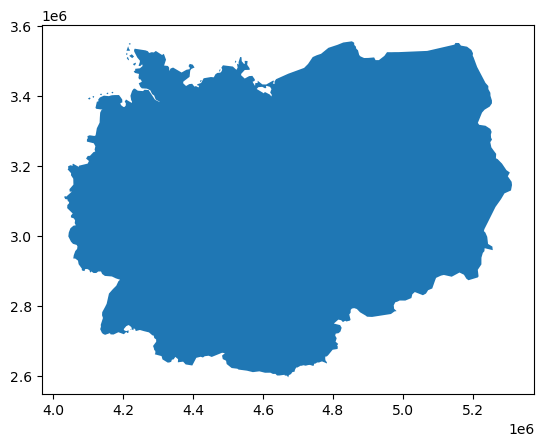

In [5]:
aoi = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1994_political")
aoi = aoi.dissolve()
aoi.plot()

In [6]:
hexed = h3fy(aoi, resolution=3)

/home/dancejod/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Text(0.5, 1.0, 'aoi_hexed')

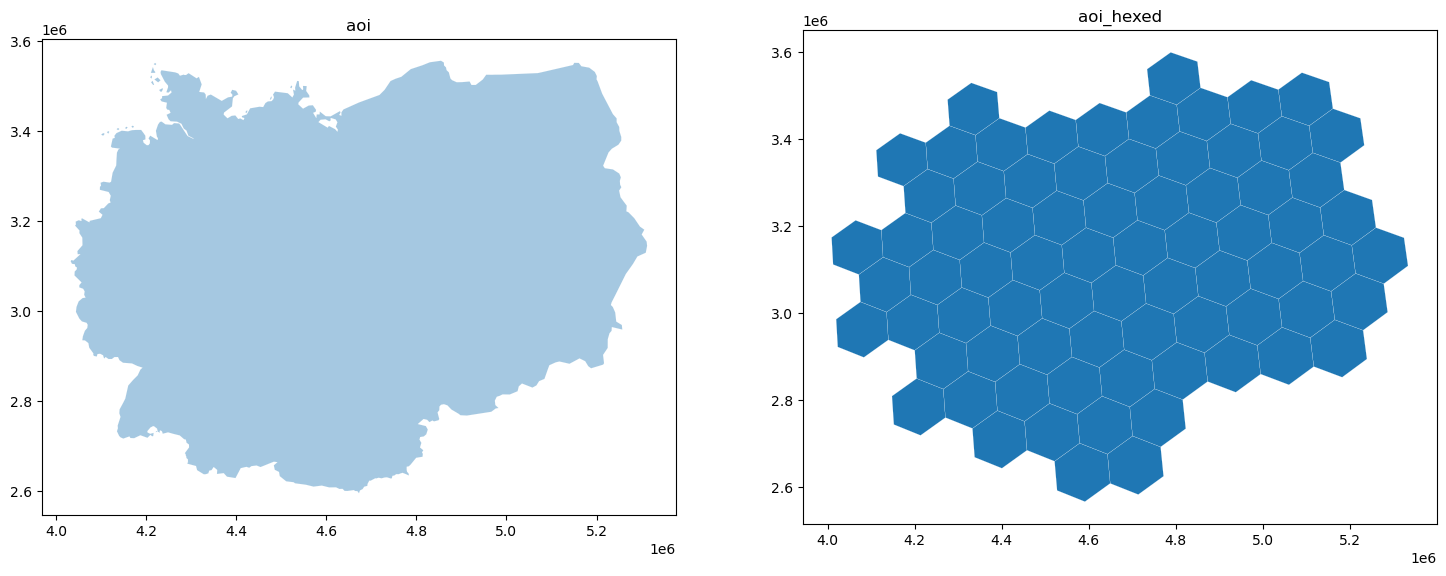

In [7]:
fig, axs = plt.subplots(1,2, figsize=(18,10))
axs=axs.flatten()

aoi.plot(ax=axs[0], alpha=0.4, linewidth=0.1, edgecolor='white')
hexed.plot(ax=axs[1], linewidth=0.1, edgecolor='white')

axs[0].set_title('aoi')
axs[1].set_title('aoi_hexed')

In [8]:
hexed

,geometry
hex_id,
831f52fffffffff,"POLYGON ((4948900.827 3247639.141, 5012283.856..."
831fabfffffffff,"POLYGON ((4322580.144 2865573.857, 4384564.554..."
831f88fffffffff,"POLYGON ((4400275.867 2642932.21, 4457929.792 ..."
831e2afffffffff,"POLYGON ((5108691.228 2942641.52, 5165268.677 ..."
831f55fffffffff,"POLYGON ((5152245.191 3530387.501, 5089637.06 ..."
...,...
831f8cfffffffff,"POLYGON ((4270425.806 2759403.495, 4332499.017..."
831f13fffffffff,"POLYGON ((4238285.619 3207119.268, 4242747.672..."
831e31fffffffff,"POLYGON ((4801848.552 2932456.398, 4794938.941..."


In [9]:
hexed.index.name = "NAME"

In [10]:
#hex_w_buildings = preprocess_data.get_building_counts_per_region(buildings, hexed, level="level_4")
joined = gpd.sjoin(buildings, hexed, how="left", predicate="within")
data = joined.groupby("NAME")["level_4"].value_counts().unstack().fillna(0)

In [11]:
data_norm = preprocess_data.normalize_building_counts(data)

In [12]:
data_norm

NAME,831e00fffffffff,831e01fffffffff,831e04fffffffff,831e05fffffffff,831e06fffffffff,831e0cfffffffff,831e10fffffffff,831e14fffffffff,831e15fffffffff,831e16fffffffff,...,831fa1fffffffff,831fa3fffffffff,831fa5fffffffff,831fa8fffffffff,831fa9fffffffff,831faafffffffff,831fabfffffffff,831facfffffffff,831fadfffffffff,831faefffffffff
level_4,,,,,,,,,,,,,,,,,,,,,
1,0.005493,0.003354,0.012151,0.004824,0.019801,0.001550,0.002361,0.001667,0.008115,0.000588,...,0.074227,0.015106,0.144839,0.029871,0.015195,0.055894,0.024886,0.025200,0.031198,0.107503
2,0.001960,0.003012,0.005138,0.001094,0.049862,0.001237,0.002877,0.002571,0.029176,0.000000,...,0.076999,0.008125,0.140778,0.025066,0.016854,0.026487,0.023897,0.015713,0.056299,0.085780
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.126897,0.115862,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125517
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.137339,0.000000,0.000000,0.000000,0.642346
5,0.017776,0.009473,0.007665,0.013097,0.029757,0.007883,0.008907,0.010062,0.032420,0.002200,...,0.012652,0.003421,0.014604,0.004669,0.008000,0.022269,0.004122,0.009111,0.009221,0.010482
6,0.007865,0.004128,0.000612,0.002030,0.004422,0.002232,0.000243,0.000358,0.001755,0.000083,...,0.054890,0.011980,0.063953,0.033838,0.020685,0.084795,0.040564,0.048169,0.021845,0.093130
7,0.026797,0.010394,0.006824,0.016389,0.008759,0.012441,0.010877,0.008715,0.012668,0.003165,...,0.049763,0.021009,0.020939,0.024235,0.026965,0.042607,0.029623,0.023600,0.021813,0.022966
8,0.019921,0.011545,0.005792,0.005161,0.015000,0.013615,0.002909,0.002281,0.006862,0.001269,...,0.052522,0.027933,0.034641,0.034123,0.036656,0.031466,0.045427,0.032593,0.029771,0.038586
9,0.002470,0.009764,0.006021,0.021404,0.001457,0.001690,0.018763,0.003129,0.005092,0.005433,...,0.000093,0.000000,0.000674,0.000000,0.000077,0.000093,0.000031,0.000028,0.000040,0.000306


In [13]:
queen = graph.Graph.build_contiguity(hexed)

In [14]:
agg = cluster.AgglomerativeClustering(n_clusters=6, connectivity=queen.sparse, metric=distance.braycurtis, linkage='complete')

In [15]:
%%time
agg.fit(data_norm.T)

CPU times: user 2.73 ms, sys: 92 μs, total: 2.82 ms
Wall time: 3.02 ms


AgglomerativeClustering(connectivity=<Compressed Sparse Row sparse array of dtype 'float64'
	with 376 stored elements and shape (75, 75)>,
                        linkage='complete',
                        metric=<function braycurtis at 0x779db35820c0>,
                        n_clusters=6)

In [16]:
hexed[['geometry']].explore(agg.labels_, categorical=True, tiles="CartoDB Positron")

In [17]:
clusters = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
labels_dict = {}

for i, k in enumerate(clusters,start=1):
    labels_dict[i] = cluster.AgglomerativeClustering(n_clusters=k, connectivity=queen.sparse, metric=distance.braycurtis, linkage='complete').fit_predict(data_norm.T)
    
labels = pd.DataFrame(labels_dict)
labels

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,1,1,1,1,0,6,6,6,6,6,2,2,2,2,2
1,0,0,0,0,0,1,0,0,3,3,3,3,3,3,1,0
2,0,0,2,2,2,2,2,2,2,2,2,0,12,12,12,12
3,0,0,0,0,4,4,1,1,1,0,4,4,4,1,0,3
4,0,1,1,1,1,0,6,6,6,6,6,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0,0,2,2,2,2,2,2,2,2,2,0,1,0,3,1
71,0,0,0,0,0,1,0,0,3,3,3,3,3,3,1,0
72,0,0,2,2,2,2,2,2,2,2,2,0,1,0,6,6
73,0,0,0,3,3,3,3,3,8,8,8,8,8,8,8,8


<Axes: xlabel='Number of clusters (k)', ylabel='Mean of the clusters'>

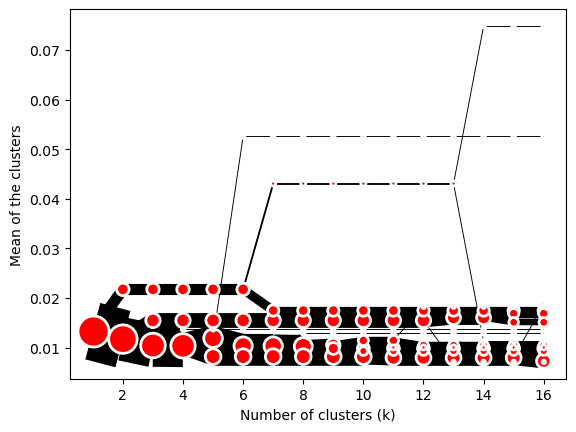

In [18]:
cgram = Clustergram.from_data(data_norm.T, labels)
cgram.plot(pca_weighted=False)

In [19]:
output_notebook()

Loading BokehJS ...

In [20]:
fig = cgram.bokeh(pca_weighted=False)
show(fig)